In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import time

from functools import partial
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, tight_layout
from PIL import Image
%matplotlib inline

import scipy
import numpy as np
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [2]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    # load any normal CNN architecture through its path
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    
    # get the layers of vgg to use in Fully Convolutional Network FCN-8s
    input_ = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return input_, keep_prob, layer3, layer4, layer7

tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [3]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    
    # go through conv 1x1 for each layer to have the same shape with upsampled layers
    # so we can add them together
    # kernel_initializer=tf.truncated_normal_initializer(stddev=0.01)
    
    # optional, stop the gradient flow here to fix the pretrained VGG weights
    #vgg_layer7_out = tf.stop_gradient(vgg_layer7_out)
    #vgg_layer4_out = tf.stop_gradient(vgg_layer4_out)
    #vgg_layer3_out = tf.stop_gradient(vgg_layer3_out)
    
    # scaling layers before feeding into conv 1x1
    vgg_layer3_out = tf.multiply(vgg_layer3_out, 0.0001)
    vgg_layer4_out = tf.multiply(vgg_layer4_out, 0.01)
    
    layer_3 = tf.layers.conv2d(vgg_layer3_out, num_classes, kernel_size=1, padding='same',
        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    layer_4 = tf.layers.conv2d(vgg_layer4_out, num_classes, kernel_size=1, padding='same',
        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    layer_7 = tf.layers.conv2d(vgg_layer7_out, num_classes, kernel_size=1, padding='same',
        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    
    decoding_layer_1 = tf.layers.conv2d_transpose(layer_7, num_classes, 
        kernel_size=4, strides=2, padding='same', 
        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    decoding_layer_1 = tf.add(decoding_layer_1, layer_4)
    
    decoding_layer_2 = tf.layers.conv2d_transpose(decoding_layer_1, num_classes, 
        kernel_size=4, strides=2, padding='same', 
        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    decoding_layer_2 = tf.add(decoding_layer_2, layer_3)
    
    decoding_layer_3 = tf.layers.conv2d_transpose(decoding_layer_2, num_classes, 
        kernel_size=16, strides=8, padding='same',
        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    
    return decoding_layer_3

tests.test_layers(layers)

Tests Passed


In [4]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # Add regularization loss and cross entropy loss together
    regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    regularization_loss = sum(regularization_losses)
    
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name='logits')
    labels = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    cross_entropy_loss = tf.add(cross_entropy_loss, regularization_loss)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
    
    return logits, train_op, cross_entropy_loss

tests.test_optimize(optimize)

Tests Passed


In [5]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    #sess.run(tf.global_variables_initializer())
    training_losses = []
    for i in range(epochs):
        start_time = time.clock()
        training_loss = 0
        for image, label in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss],
                feed_dict={input_image: image, correct_label: label, keep_prob: 0.5, learning_rate: 0.0001})
            training_loss += loss
            
        training_loss = training_loss / batch_size
        training_losses.append(training_loss)
        end_time = time.clock()
        print('Epoch {} took {} seconds. Training error was {}.'.format(i+1, end_time-start_time, training_loss))
    return training_losses

tests.test_train_nn(train_nn)

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


In [6]:
# Reference: https://github.com/tfolkman/CarND-Semantic-Segmentation/blob/master/main_notebook.ipynb
def process_image(image, sess, keep_prob, logits, input_image, image_shape):
    
    image = scipy.misc.imresize(image, image_shape)
    
    im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, input_image: [image]})
        

    label_index = np.argmax(im_softmax, axis=2)

    value_fill_1 = label_index.copy()
    value_fill_1.fill(1)
    value_fill_2 = label_index.copy()
    value_fill_2.fill(2)
    value_fill_3 = label_index.copy()
    value_fill_3.fill(3)

    segmentation1 = np.equal(label_index, value_fill_1)
    segmentation2 = np.equal(label_index, value_fill_2)
    segmentation3 = np.equal(label_index, value_fill_3)
    
    segmentation1 = segmentation1.reshape(image_shape[0], image_shape[1], 1)
    segmentation2 = segmentation2.reshape(image_shape[0], image_shape[1], 1)
    segmentation3 = segmentation3.reshape(image_shape[0], image_shape[1], 1)
    mask1 = np.dot(segmentation1, np.array([[0, 255, 0, 127]]))
    mask1 = scipy.misc.toimage(mask1, mode="RGBA")
    mask2 = np.dot(segmentation2, np.array([[0, 0, 255, 127]]))
    mask2 = scipy.misc.toimage(mask2, mode="RGBA")
    mask3 = np.dot(segmentation3, np.array([[255, 242, 0, 127]]))
    mask3 = scipy.misc.toimage(mask3, mode="RGBA")
    street_im = scipy.misc.toimage(image)
    street_im.paste(mask1, box=None, mask=mask1)
    street_im.paste(mask2, box=None, mask=mask2)
    street_im.paste(mask3, box=None, mask=mask3)
    
    return np.array(street_im)

In [7]:
def run(retrain=True, predict_image = False, predict_video = False): # operation flags
    
    tf.reset_default_graph()   # need to reset before run a new model
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    training_losses = [0]
    
    with tf.Session() as sess:
        

        if retrain:
            # Path to vgg model
            vgg_path = os.path.join(data_dir, 'vgg')
            # Create function to get batches
            get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

            # OPTIONAL: Augment Images for better results
            #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

            # TODO: Build NN using load_vgg, layers, and optimize function
            epochs = 30
            batch_size = 8

            # TF placeholders
            correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
            learning_rate = tf.placeholder(tf.float32, name='learning_rate')

            input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
            nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
            logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, learning_rate, num_classes)

            # TODO: Train NN using the train_nn function
            sess.run(tf.global_variables_initializer())
        
            saver = tf.train.Saver()
            training_losses = train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
                correct_label, keep_prob, learning_rate)
            saver.save(sess, 'segmentation_model')
            
            # TODO: Save inference data using helper.save_inference_samples
            helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
        if predict_image:
            # Load model
            saver = tf.train.import_meta_graph('segmentation_model.meta')
            saver.restore(sess,tf.train.latest_checkpoint('./'))
            
            # Extract tensors
            graph = tf.get_default_graph()
            input_image = graph.get_tensor_by_name('image_input:0')
            keep_prob = graph.get_tensor_by_name('keep_prob:0')
            logits = graph.get_tensor_by_name('logits:0')
            
            img = scipy.misc.imread("./data/data_road/training/image_2/um_000007.png")
            output_img = process_image(img, sess, keep_prob, logits, input_image, image_shape)
            plt.imshow(output_img)
            plt.tight_layout()
            
        # OPTIONAL: Apply the trained model to a video
        
        if predict_video:
             # Load model
            saver = tf.train.import_meta_graph('segmentation_model.meta')
            saver.restore(sess,tf.train.latest_checkpoint('./'))
            
            # Extract tensors
            graph = tf.get_default_graph()
            input_image = graph.get_tensor_by_name('image_input:0')
            keep_prob = graph.get_tensor_by_name('keep_prob:0')
            logits = graph.get_tensor_by_name('logits:0')
            
            output_video = 'driving_output.mp4'
            input_video = 'driving.mp4'
            
            partial_process_image = partial(process_image,  sess=sess, keep_prob=keep_prob, logits=logits, 
                                            input_image=input_image, image_shape=image_shape)

            clip1 = VideoFileClip(input_video)            
            video_clip = clip1.fl_image(partial_process_image)
            %time video_clip.write_videofile(output_video, audio=False)
        
    return training_losses

In [ ]:
if __name__ == '__main__':
    
    training_losses = run(retrain=True)

    #_ = run(predict_image=True)
    
    #_ = run(predict_video=True)


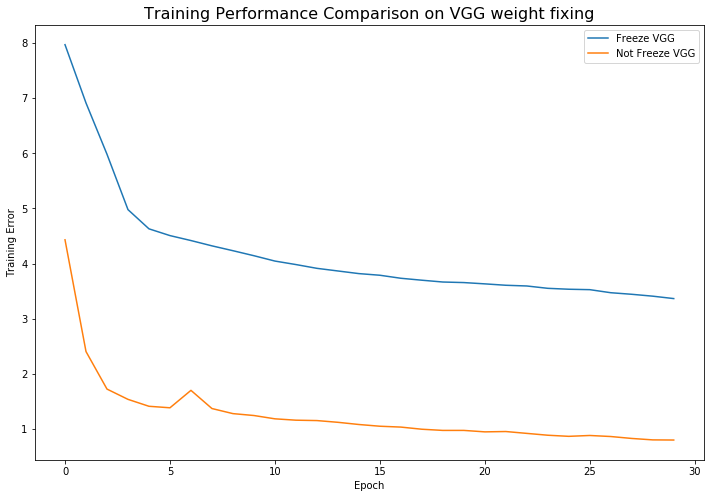

In [12]:
with open('a.pickle', 'rb') as f:
    a = pickle.load(f)
with open('b.pickle', 'rb') as f:
    b = pickle.load(f)
plt.figure(figsize=(12,8))
plt.plot(range(len(a)), a, label='Freeze VGG')
plt.plot(range(len(b)), b, label='Not Freeze VGG')
plt.xlabel('Epoch')
plt.ylabel('Training Error')
plt.legend()
plt.title('Training Performance Comparison on VGG weight fixing', fontsize=16)


In [ ]:
''' Not fixing the pretrained VGG.
Epoch 1 took 33.294155000000046 seconds. Training error was 4.355113133788109.
Epoch 2 took 32.79390999999987 seconds. Training error was 2.294324889779091.
Epoch 3 took 32.78882199999998 seconds. Training error was 1.6767770536243916.
Epoch 4 took 33.59218800000008 seconds. Training error was 1.5267454460263252.
Epoch 5 took 33.40632900000037 seconds. Training error was 1.4614848233759403.
Epoch 6 took 33.845368000000235 seconds. Training error was 1.3017204776406288.
Epoch 7 took 32.85208799999964 seconds. Training error was 1.219868490472436.
Epoch 8 took 33.022003999999924 seconds. Training error was 1.1810611486434937.
Epoch 9 took 32.95940900000005 seconds. Training error was 1.1146413162350655.
Epoch 10 took 32.82030600000007 seconds. Training error was 1.0735535342246294.

Epoch 11 took 32.837132999999994 seconds. Training error was 1.0871983636170626.
Epoch 12 took 32.96257400000013 seconds. Training error was 1.0119769256561995.
Epoch 13 took 33.318541000000096 seconds. Training error was 0.9560791347175837.
Epoch 14 took 33.16982400000006 seconds. Training error was 0.9342574644833803.
Epoch 15 took 33.057060999999976 seconds. Training error was 0.9102634228765965.
Epoch 16 took 32.75053500000013 seconds. Training error was 0.8956393226981163.
Epoch 17 took 33.13380099999995 seconds. Training error was 0.8831686731427908.
Epoch 18 took 33.01841599999989 seconds. Training error was 0.8397952504456043.
Epoch 19 took 33.354913000000124 seconds. Training error was 0.8161631133407354.
Epoch 20 took 33.174782999999934 seconds. Training error was 0.7997701484709978.

Epoch 21 took 33.21742499999982 seconds. Training error was 0.7759448476135731.
Epoch 22 took 33.45178900000019 seconds. Training error was 0.7640944216400385.
Epoch 23 took 32.90679999999975 seconds. Training error was 0.7495317533612251.
Epoch 24 took 33.175846999999976 seconds. Training error was 0.7308971844613552.
Epoch 25 took 33.099031000000195 seconds. Training error was 0.715748380869627.
Epoch 26 took 33.07040899999993 seconds. Training error was 0.6972469165921211.
Epoch 27 took 32.765405999999984 seconds. Training error was 0.6919837463647127.
Epoch 28 took 32.96255999999994 seconds. Training error was 0.7177233286201954.
Epoch 29 took 33.16145199999983 seconds. Training error was 0.6936861649155617.
Epoch 30 took 33.04784900000004 seconds. Training error was 0.6718434989452362.

Training Finished.
'''

In [ ]:
''' Fixing the pretrained VGG.
Epoch 1 took 10.65151800000001 seconds. Training error was 7.970224301020305.
Epoch 2 took 10.627881000000002 seconds. Training error was 6.912810534238815.
Epoch 3 took 10.277176999999995 seconds. Training error was 5.982533663511276.
Epoch 4 took 10.623189999999965 seconds. Training error was 4.977942928671837.
Epoch 5 took 10.036455999999987 seconds. Training error was 4.6294913192590075.
[I 21:39:44.448 NotebookApp] Saving file at /main_v1.ipynb
Epoch 6 took 9.911776999999972 seconds. Training error was 4.506999557216962.
Epoch 7 took 10.548872000000017 seconds. Training error was 4.41711903611819.
Epoch 8 took 10.16299399999997 seconds. Training error was 4.320907071232796.
Epoch 9 took 10.536592000000041 seconds. Training error was 4.232912018895149.
Epoch 10 took 10.200428999999986 seconds. Training error was 4.142017091313998.
Epoch 11 took 10.802334999999971 seconds. Training error was 4.044963305195172.
[I 21:41:44.448 NotebookApp] Saving file at /main_v1.ipynb
Epoch 12 took 10.687178000000017 seconds. Training error was 3.981622929374377.
Epoch 13 took 10.680382000000009 seconds. Training error was 3.9130617827177048.
Epoch 14 took 10.589298999999983 seconds. Training error was 3.865209639072418.
Epoch 15 took 10.26046400000007 seconds. Training error was 3.8174353490273156.
Epoch 16 took 10.56921699999998 seconds. Training error was 3.7876391857862473.
Epoch 17 took 10.396468999999911 seconds. Training error was 3.7328649212916694.
Epoch 18 took 10.673835000000054 seconds. Training error was 3.697610706090927.
Epoch 19 took 11.174310999999989 seconds. Training error was 3.664851283033689.
Epoch 20 took 10.398307000000045 seconds. Training error was 3.6547539631525674.
Epoch 21 took 10.855835999999954 seconds. Training error was 3.631337985396385.
Epoch 22 took 10.505112999999938 seconds. Training error was 3.6059836546579995.
Epoch 23 took 10.652113999999983 seconds. Training error was 3.5929319063822427.
Epoch 24 took 10.330239000000006 seconds. Training error was 3.550444722175598.
Epoch 25 took 10.145632999999975 seconds. Training error was 3.533862223227819.
Epoch 26 took 10.27209700000003 seconds. Training error was 3.5261480708916983.
Epoch 27 took 10.46190399999989 seconds. Training error was 3.470730890830358.
Epoch 28 took 10.857665999999995 seconds. Training error was 3.442230135202408.
Epoch 29 took 10.472712999999999 seconds. Training error was 3.4080870946248374.
Epoch 30 took 10.880441000000019 seconds. Training error was 3.3643658260504403.
Training Finished.
'''